In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline

#Número Top de Gens. En aquest cas vull els TOP500
n=500

#Fitxer que contè en CV els gens. excloent MITOCONDRIALS, més epxressats de manera ordenada decreixent.
teixits = pd.read_csv('D:/TFM/ANALISI_MODELS/Datasets/all_gensCV_noversio_NOMITO_ZA.csv',sep =",")

In [2]:
#data = teixits.iloc[:, 1:4]
data=teixits

In [3]:
if (n==0 or n>(len(teixits.columns)-3)):
    n=len(teixits.columns)-3
    
data = teixits.iloc[:, 2:n+3]

In [4]:
data

,SMTSD,ENSG00000248527,ENSG00000087086,ENSG00000131095,ENSG00000197971,ENSG00000225630,ENSG00000123560,ENSG00000075624,ENSG00000111640,ENSG00000120885,...,ENSG00000204843,ENSG00000173726,ENSG00000148180,ENSG00000147416,ENSG00000112514,ENSG00000167702,ENSG00000067715,ENSG00000130066,ENSG00000156482,ENSG00000170889
0,Brain - Cortex,5852.0,2444.0,993.4,2566.00,1408.0,1436.00,1418.0,1433.0,960.5,...,197.1,166.30,153.60,227.10,126.6,159.3,235.40,116.40,108.00,96.57
1,Brain - Cerebellum,4863.0,1229.0,479.8,102.70,801.8,77.02,1275.0,1306.0,1045.0,...,212.9,103.60,61.99,161.80,157.1,359.6,163.60,84.25,135.50,98.23
2,Brain - Cortex,6309.0,1653.0,842.0,192.80,1281.0,269.60,1109.0,1301.0,1264.0,...,141.3,123.50,68.05,153.30,123.5,170.4,139.60,85.55,73.41,74.75
3,Brain - Cerebellum,5897.0,1082.0,521.1,360.60,969.4,207.40,936.8,890.8,885.3,...,180.7,78.19,53.31,113.80,132.9,295.6,92.02,67.97,119.30,102.90
4,Brain - Cortex,5461.0,1551.0,695.9,215.40,1118.0,432.20,1574.0,1814.0,924.4,...,212.6,157.10,67.90,229.20,174.7,254.6,206.30,103.00,82.10,97.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2636,Brain - Cortex,6258.0,1646.0,907.6,385.10,943.8,372.80,1401.0,1805.0,1457.0,...,219.3,166.60,59.19,218.60,157.8,214.4,214.60,142.90,74.76,97.40
2637,Brain - Cerebellum,4839.0,1415.0,1328.0,184.80,946.5,166.50,1143.0,1249.0,1883.0,...,206.6,102.60,103.20,146.40,156.6,245.5,119.60,78.31,153.20,103.80
2638,Brain - Cortex,4931.0,2849.0,1268.0,73.87,1225.0,120.40,2797.0,1188.0,1244.0,...,122.9,126.20,285.00,131.40,123.3,165.7,108.50,246.40,137.40,143.10
2639,Brain - Cerebellum,5456.0,894.4,805.0,28.05,1152.0,44.74,1001.0,769.1,1571.0,...,160.4,121.20,81.91,134.40,107.1,202.0,170.60,80.98,115.00,91.29


In [5]:
#Creació conjunt train i test

x,y=data.iloc[:, 1:n+1],data.iloc[:, 0]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=123)

x_train = np.log2(x_train+1)
x_test = np.log2(x_test+1)

In [6]:
#Definim PCA

pca = PCA()

z= pca.fit_transform(x_train)

x_train_pca = z
x_test_pca  = pca.transform(x_test)

22 components expliquen un 95% de la variança. De 500 dimensions a 22


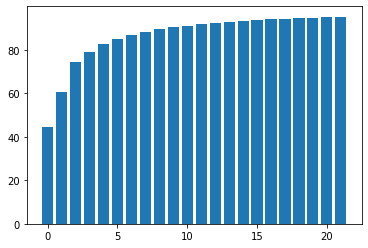

In [7]:
total = sum(pca.explained_variance_)

k = 0
current_variance = 0
while current_variance/total < 0.95:
    current_variance += pca.explained_variance_[k]
    k = k + 1
    
print(k, " components expliquen un 95% de la variança. De ",n," dimensions a ", k, sep='')

pca = PCA(n_components=k)

x_train.pca = pca.fit(x_train)
x_train_pca = pca.transform(x_train)

x_test_pca = pca.transform(x_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp);

In [8]:
#Dinàmicament agafo el numero de Dimensions de PCA: k

principalDf = pd.DataFrame(data = x_train_pca[:,0:k])
             #, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principalDf.head(5)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,3.563168,-8.585746,-5.140684,4.583743,-4.801281,-2.062104,-1.450367,0.597487,-5.231507,-3.169702,...,-1.100389,-2.024833,2.069338,-1.142845,2.316995,-0.053448,2.686965,-2.529104,-1.644841,0.934406
1,-16.642816,17.049417,-7.165563,-3.655195,-1.107046,1.363871,-2.080491,-0.482284,-1.245442,0.086809,...,-1.645204,-0.163457,-0.903931,1.146426,1.033165,-0.814122,1.242770,0.126520,0.501335,1.402929
2,24.374154,2.548749,-9.358717,6.857725,1.083755,0.964568,9.472721,4.299930,4.053391,-2.795091,...,8.186558,-0.651458,-0.940457,4.469779,-0.114659,-1.485383,0.576751,-0.226421,-0.908091,-0.893461
3,39.911180,3.826236,-10.976144,2.589877,-0.479961,-1.005534,-0.543783,-3.986581,1.248007,-2.012047,...,-1.208747,0.745897,2.222066,-0.919991,0.420115,1.410141,-1.460044,3.731413,-0.949987,2.764629
4,12.792924,-3.693854,-7.183039,3.717175,-4.421738,4.107270,-0.775235,-2.481123,-0.407616,-0.119977,...,-0.597738,1.994755,-2.053490,0.232978,0.004501,0.092047,-1.804322,-0.321557,-1.227506,-0.226915


In [9]:
x_train_pca[:,0:11].shape

(2112, 11)

In [10]:
principalDf.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

finalDF = pd.concat([principalDf, y_train], axis=1)

finalDF.head(5)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,SMTSD
0,3.563168,-8.585746,-5.140684,4.583743,-4.801281,-2.062104,-1.450367,0.597487,-5.231507,-3.169702,...,-2.024833,2.069338,-1.142845,2.316995,-0.053448,2.686965,-2.529104,-1.644841,0.934406,Brain - Hippocampus
1,-16.642816,17.049417,-7.165563,-3.655195,-1.107046,1.363871,-2.080491,-0.482284,-1.245442,0.086809,...,-0.163457,-0.903931,1.146426,1.033165,-0.814122,1.242770,0.126520,0.501335,1.402929,Brain - Cerebellum
2,24.374154,2.548749,-9.358717,6.857725,1.083755,0.964568,9.472721,4.299930,4.053391,-2.795091,...,-0.651458,-0.940457,4.469779,-0.114659,-1.485383,0.576751,-0.226421,-0.908091,-0.893461,Brain - Frontal Cortex (BA9)
3,39.911180,3.826236,-10.976144,2.589877,-0.479961,-1.005534,-0.543783,-3.986581,1.248007,-2.012047,...,0.745897,2.222066,-0.919991,0.420115,1.410141,-1.460044,3.731413,-0.949987,2.764629,Brain - Nucleus accumbens (basal ganglia)
4,12.792924,-3.693854,-7.183039,3.717175,-4.421738,4.107270,-0.775235,-2.481123,-0.407616,-0.119977,...,1.994755,-2.053490,0.232978,0.004501,0.092047,-1.804322,-0.321557,-1.227506,-0.226915,Brain - Frontal Cortex (BA9)


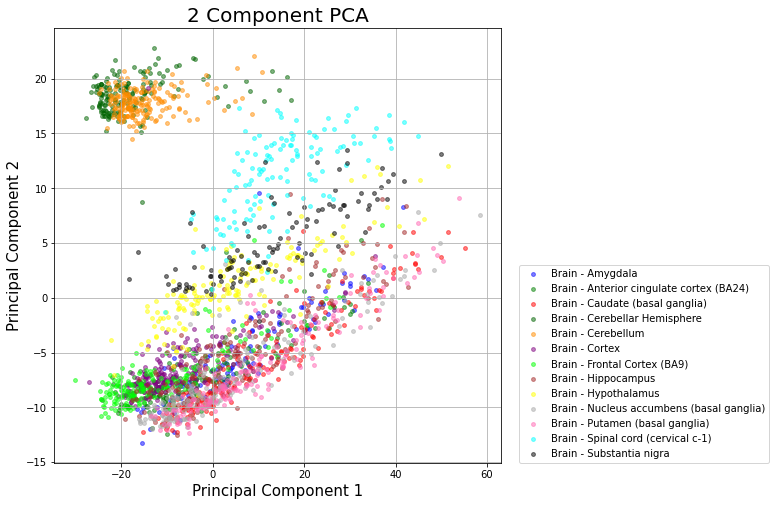

In [11]:
#Visualitzo la projecció 2D

fig = plt.figure(figsize = (8,8))

ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = ['Brain - Amygdala',
           'Brain - Anterior cingulate cortex (BA24)',
           'Brain - Caudate (basal ganglia)',
           'Brain - Cerebellar Hemisphere',
           'Brain - Cerebellum',
           'Brain - Cortex',
           'Brain - Frontal Cortex (BA9)',
           'Brain - Hippocampus', 
           'Brain - Hypothalamus',       
           'Brain - Nucleus accumbens (basal ganglia)', 
           'Brain - Putamen (basal ganglia)',
           'Brain - Spinal cord (cervical c-1)',
           'Brain - Substantia nigra']

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 13))

colors = {'red':   ((0.0, 0.0, 0.0),
                    (0.5, 0.0, 0.1),
                    (1.0, 1.0, 1.0)),

          'green': ((0.0, 0.0, 0.0),
                    (1.0, 0.0, 0.0)),

          'blue':  ((0.0, 0.0, 1.0),
                    (0.5, 0.1, 0.0),
                    (1.0, 0.0, 0.0))
          }

colors = {"black","hotpink", "purple", "green","lime", "blue", "red","yellow","cyan", "darkgreen","darkorange", "brown", "darkgrey"}

for target, color in zip(targets,colors):
    indicesToKeep = finalDF['SMTSD'] == target    
    ax.scatter(finalDF.loc[indicesToKeep, 0]
               , finalDF.loc[indicesToKeep, 1]
               , c = color               
               , s = 15, alpha=0.5)
ax.legend(targets, loc=(1.04,0))


ax.grid()

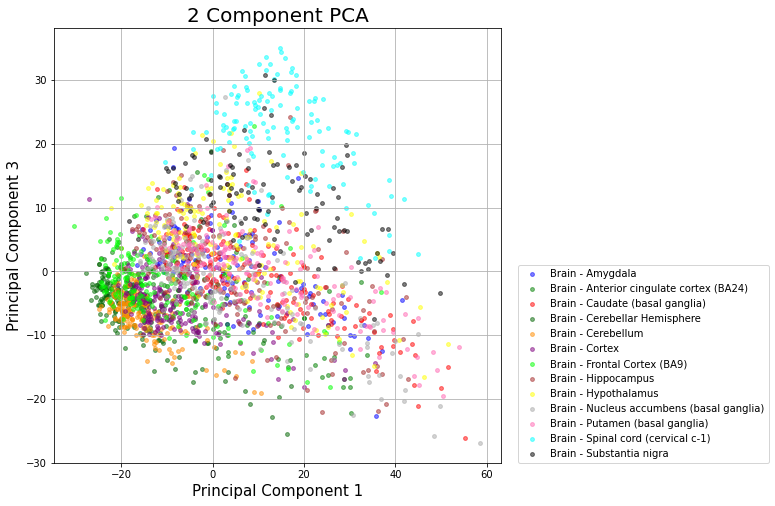

In [12]:

fig = plt.figure(figsize = (8,8))

ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = ['Brain - Amygdala',
           'Brain - Anterior cingulate cortex (BA24)',
           'Brain - Caudate (basal ganglia)',
           'Brain - Cerebellar Hemisphere',
           'Brain - Cerebellum',
           'Brain - Cortex',
           'Brain - Frontal Cortex (BA9)',
           'Brain - Hippocampus', 
           'Brain - Hypothalamus',       
           'Brain - Nucleus accumbens (basal ganglia)', 
           'Brain - Putamen (basal ganglia)',
           'Brain - Spinal cord (cervical c-1)',
           'Brain - Substantia nigra']

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, 13))

colors = {'red':   ((0.0, 0.0, 0.0),
                    (0.5, 0.0, 0.1),
                    (1.0, 1.0, 1.0)),

          'green': ((0.0, 0.0, 0.0),
                    (1.0, 0.0, 0.0)),

          'blue':  ((0.0, 0.0, 1.0),
                    (0.5, 0.1, 0.0),
                    (1.0, 0.0, 0.0))
          }

colors = {"black","hotpink", "purple", "green","lime", "blue", "red","yellow","cyan", "darkgreen","darkorange", "brown", "darkgrey"}

for target, color in zip(targets,colors):
    indicesToKeep = finalDF['SMTSD'] == target    
    ax.scatter(finalDF.loc[indicesToKeep, 0]
               , finalDF.loc[indicesToKeep, 2]
               , c = color               
               , s = 15, alpha=0.5)
ax.legend(targets, loc=(1.04,0))


ax.grid()

<b>tSNE Perplexity 30</b>

In [13]:
tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, verbose=1, random_state=1234)

points = tsne.fit_transform(x_train)

tsne_df = pd.DataFrame({'X':points[:,0],
                        'Y':points[:,1],
                        'Tipus Teixit':y_train})
tsne_df.head()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2112 samples in 0.001s...
[t-SNE] Computed neighbors for 2112 samples in 0.219s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2112
[t-SNE] Computed conditional probabilities for sample 2000 / 2112
[t-SNE] Computed conditional probabilities for sample 2112 / 2112
[t-SNE] Mean sigma: 4.450518
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.024895
[t-SNE] KL divergence after 1000 iterations: 0.949321


,X,Y,Tipus Teixit
0,-12.192844,-11.656596,Brain - Hippocampus
1,48.423668,-10.146123,Brain - Cerebellum
2,-14.091950,7.139014,Brain - Frontal Cortex (BA9)
3,-14.119723,21.777924,Brain - Nucleus accumbens (basal ganglia)
4,-4.435991,-2.944871,Brain - Frontal Cortex (BA9)


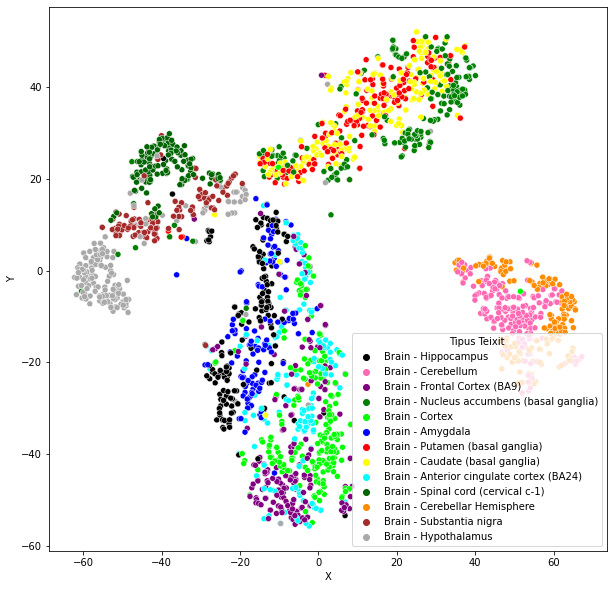

In [14]:
plt.figure(figsize=(10, 10))

sns.scatterplot(x="X", y="Y",
              hue="Tipus Teixit",
              palette=["black","hotpink", "purple", "green","lime", "blue", "red","yellow","cyan", "darkgreen","darkorange", "brown", "darkgrey"],
              #legend='full',              
              data=tsne_df);

<b>Realització de Models</b>

<b>Model Classificador kNN</b>

In [15]:
#Emprant Reducció PCA
#============================

# Grid d'hiperparàmetres
# ==============================================================================
param_grid={"n_neighbors":range(5,25), "weights": ["uniform","distance"]}


# Validació creuada
# ==============================================================================
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()


grid = GridSearchCV(model , param_grid = param_grid,
                           cv=10, scoring = 'accuracy', n_jobs=-1,                            
                           verbose = 1,                           
                           return_train_score = True)

#Tots els PCA recomanats per 95%
_ = grid.fit(X = x_train_pca, y = y_train)


# Càlculs

means = _.cv_results_["mean_test_score"]
stds = _.cv_results_["std_test_score"]
params = _.cv_results_["params"]
ranks = _.cv_results_["rank_test_score"]

for ordre, mitjana, std, parametres in zip(ranks, means, stds, params):
    print(ordre,"# Prec. mitjana: ",mitjana*100," desv.: ", std*100, " paràmetres: ",parametres)


# Resultats del grid
# ==============================================================================
resultats = pd.DataFrame(grid.cv_results_)
resultats.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)


# Millors hiperparàmetres amb validació creuada
# ==============================================================================
print("----------------------------------------")
print("(kNN) Millors hiperparàmetres trobats (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

model2 = grid.best_estimator_

r_model2 = grid.best_score_

# Prediccions test
# ==============================================================================

prediccions2 = model2.predict(x_test_pca)

# Accuracy de test del model
# ==============================================================================
accuracy2 = accuracy_score(
            y_true    = y_test,
            y_pred    = prediccions2,
            normalize = True
           )
print("")
print(f"(kNN) El accuracy de test és: {100*accuracy2}%")


# Matriu de confusió de les prediccions de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test.ravel(),
    prediccions2,
    rownames=['Real'],
    colnames=['Predicció']
)
confusion_matrix

Fitting 10 folds for each of 40 candidates, totalling 400 fits
20 # Prec. mitjana:  74.0995260663507  desv.:  2.170930182276464  paràmetres:  {'n_neighbors': 5, 'weights': 'uniform'}
21 # Prec. mitjana:  74.05123848698918  desv.:  2.5309112469813613  paràmetres:  {'n_neighbors': 5, 'weights': 'distance'}
37 # Prec. mitjana:  73.34145578109631  desv.:  1.6607822827129082  paràmetres:  {'n_neighbors': 6, 'weights': 'uniform'}
13 # Prec. mitjana:  74.33492801573817  desv.:  1.9771299627440613  paràmetres:  {'n_neighbors': 6, 'weights': 'distance'}
19 # Prec. mitjana:  74.14736653849594  desv.:  1.9013289440519998  paràmetres:  {'n_neighbors': 7, 'weights': 'uniform'}
18 # Prec. mitjana:  74.1475900921041  desv.:  2.3332653352269834  paràmetres:  {'n_neighbors': 7, 'weights': 'distance'}
3 # Prec. mitjana:  74.67003487436288  desv.:  2.0678987167357064  paràmetres:  {'n_neighbors': 8, 'weights': 'uniform'}
1 # Prec. mitjana:  75.18934990610748  desv.:  1.920270593811612  paràmetres:  {'n_n

Predicció,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),Brain - Cerebellar Hemisphere,Brain - Cerebellum,Brain - Cortex,Brain - Frontal Cortex (BA9),Brain - Hippocampus,Brain - Hypothalamus,Brain - Nucleus accumbens (basal ganglia),Brain - Putamen (basal ganglia),Brain - Spinal cord (cervical c-1),Brain - Substantia nigra
Real,,,,,,,,,,,,,
Brain - Amygdala,24,1,0,0,0,0,0,9,0,0,0,0,0
Brain - Anterior cingulate cortex (BA24),1,15,0,0,0,1,11,0,0,0,0,0,0
Brain - Caudate (basal ganglia),0,0,34,0,0,0,1,0,0,4,13,0,0
Brain - Cerebellar Hemisphere,0,0,0,43,8,0,0,0,0,0,0,0,0
Brain - Cerebellum,0,0,0,6,49,0,0,0,0,0,0,0,0
Brain - Cortex,1,2,0,0,0,38,0,1,0,0,0,0,0
Brain - Frontal Cortex (BA9),3,7,0,0,0,2,21,0,0,0,0,0,0
Brain - Hippocampus,9,0,0,0,0,0,2,29,0,0,0,0,1
Brain - Hypothalamus,0,0,0,1,0,0,0,0,33,1,0,1,3


<b>SVM</b>

In [16]:
#Emprant Reducció PCA
#============================
# Grid d'hiperparàmetres
# ==============================================================================
param_grid = {"C": (0.01, 0.1, 1, 10, 100, 150, 200, 250 , 300, 1000), "gamma": (0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.005, 0.1,0.5, 1, 10)}

# Validació creuada
# ==============================================================================
from sklearn import svm

model = svm.SVC()
grid = GridSearchCV(model, param_grid = param_grid,                           
                           cv=10, scoring = 'accuracy', n_jobs=-1,                            
                           verbose = 1,
                           return_train_score = True)

#Tots els PCA recomanats per 95%
_ = grid.fit(X = x_train_pca, y = y_train)


# Càlculs

means = _.cv_results_["mean_test_score"]
stds = _.cv_results_["std_test_score"]
params = _.cv_results_["params"]
ranks = _.cv_results_["rank_test_score"]

for ordre, mitjana, std, parametres in zip(ranks, means, stds, params):
    print(ordre,"# Prec. mitjana: ",mitjana*100," desv.: ", std*100, " paràmetres: ",parametres)

    
# Resultats del grid
# ==============================================================================
resultats = pd.DataFrame(grid.cv_results_)
resultats.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)

# Millors hiperparàmetres amb validació creuada
# ==============================================================================
print("----------------------------------------")
print("(SVM) Millors hiperparàmetres trobats (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

model3 = grid.best_estimator_

r_model3 = grid.best_score_


# Prediccions test
# ==============================================================================

prediccions3 = model3.predict(x_test_pca)

# Accuracy de test del model
# ==============================================================================
accuracy3 = accuracy_score(
            y_true    = y_test,
            y_pred    = prediccions3,
            normalize = True
           )
print("")
print(f"(SVM) El accuracy de test és: {100*accuracy3}%")


# Matriu de confusió de les prediccions de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test.ravel(),
    prediccions3,
    rownames=['Real'],
    colnames=['Predicció']
)
confusion_matrix

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
71 # Prec. mitjana:  10.038004113386389  desv.:  0.19511709742031305  paràmetres:  {'C': 0.01, 'gamma': 1e-06}
71 # Prec. mitjana:  10.038004113386389  desv.:  0.19511709742031305  paràmetres:  {'C': 0.01, 'gamma': 1e-05}
71 # Prec. mitjana:  10.038004113386389  desv.:  0.19511709742031305  paràmetres:  {'C': 0.01, 'gamma': 0.0001}
61 # Prec. mitjana:  20.54904766162926  desv.:  0.7334800356472825  paràmetres:  {'C': 0.01, 'gamma': 0.001}
62 # Prec. mitjana:  11.363900563355092  desv.:  0.7378258396860824  paràmetres:  {'C': 0.01, 'gamma': 0.01}
60 # Prec. mitjana:  24.006304211749978  desv.:  1.6639433851047885  paràmetres:  {'C': 0.01, 'gamma': 0.005}
71 # Prec. mitjana:  10.038004113386389  desv.:  0.19511709742031305  paràmetres:  {'C': 0.01, 'gamma': 0.1}
71 # Prec. mitjana:  10.038004113386389  desv.:  0.19511709742031305  paràmetres:  {'C': 0.01, 'gamma': 0.5}
71 # Prec. mitjana:  10.038004113386389  desv.:  0.1951

Predicció,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),Brain - Cerebellar Hemisphere,Brain - Cerebellum,Brain - Cortex,Brain - Frontal Cortex (BA9),Brain - Hippocampus,Brain - Hypothalamus,Brain - Nucleus accumbens (basal ganglia),Brain - Putamen (basal ganglia),Brain - Spinal cord (cervical c-1),Brain - Substantia nigra
Real,,,,,,,,,,,,,
Brain - Amygdala,32,0,0,0,0,0,0,2,0,0,0,0,0
Brain - Anterior cingulate cortex (BA24),1,23,0,0,0,1,3,0,0,0,0,0,0
Brain - Caudate (basal ganglia),0,0,44,0,0,0,1,0,0,2,5,0,0
Brain - Cerebellar Hemisphere,0,0,0,51,0,0,0,0,0,0,0,0,0
Brain - Cerebellum,0,0,0,2,53,0,0,0,0,0,0,0,0
Brain - Cortex,0,1,0,0,0,39,2,0,0,0,0,0,0
Brain - Frontal Cortex (BA9),0,1,0,0,0,0,32,0,0,0,0,0,0
Brain - Hippocampus,7,2,0,0,0,0,0,31,1,0,0,0,0
Brain - Hypothalamus,0,0,0,1,0,0,0,0,33,2,0,0,3


<b>Arbres de decisió</b>

In [17]:
#Emprant Reducció PCA
#============================

# Grid d'hiperparàmetres
# ==============================================================================
param_grid={'min_samples_split' :(2, 10, 20, 50 ,75,100,500,1000),'max_depth':(4,5,6,7,8,9,10,20,50,100,200,300,400,450,460,470,500,550,600,650,700,1000)}

# Validació creuada
# ==============================================================================
import sklearn.tree

model=sklearn.tree.DecisionTreeClassifier()

grid = GridSearchCV(model, param_grid = param_grid, 
                           cv=10, scoring = 'accuracy', n_jobs=-1,                            
                           verbose = 1,
                           return_train_score = True)

#Tots els PCA recomanats per 95%
_ = grid.fit(X = x_train_pca, y = y_train)


# Càlculs

means = _.cv_results_["mean_test_score"]
stds = _.cv_results_["std_test_score"]
params = _.cv_results_["params"]
ranks = _.cv_results_["rank_test_score"]

for ordre, mitjana, std, parametres in zip(ranks, means, stds, params):
    print(ordre,"# Prec. mitjana: ",mitjana*100," desv.: ", std*100, " paràmetres: ",parametres)


# Resultats del grid
# ==============================================================================
resultats = pd.DataFrame(grid.cv_results_)
resultats.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)


# Millors hiperparàmetres amb validació creuada
# ==============================================================================
print("----------------------------------------")
print("(Arbre de Decissió) Millors hiperparàmetres trobats (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

model4 = grid.best_estimator_

r_model4 = grid.best_score_

# Prediccions test
# ==============================================================================

prediccions4 = model4.predict(x_test_pca)

# Accuracy de test del model
# ==============================================================================
accuracy4 = accuracy_score(
            y_true    = y_test,
            y_pred    = prediccions4,
            normalize = True
           )
print("")
print(f"(Arbre de Decissió) El accuracy de test és: {100*accuracy4}%")


# Matriu de confusió de les prediccions de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test.ravel(),
    prediccions4,
    rownames=['Real'],
    colnames=['Predicció']
)
confusion_matrix

Fitting 10 folds for each of 176 candidates, totalling 1760 fits
128 # Prec. mitjana:  51.79960654564966  desv.:  2.422836835349576  paràmetres:  {'max_depth': 4, 'min_samples_split': 2}
129 # Prec. mitjana:  51.75266028793706  desv.:  2.393223601103785  paràmetres:  {'max_depth': 4, 'min_samples_split': 10}
127 # Prec. mitjana:  51.894616829115634  desv.:  2.3641660779193616  paràmetres:  {'max_depth': 4, 'min_samples_split': 20}
130 # Prec. mitjana:  51.752436734328896  desv.:  2.2626360750333014  paràmetres:  {'max_depth': 4, 'min_samples_split': 50}
131 # Prec. mitjana:  51.65765000447108  desv.:  2.3711692182733937  paràmetres:  {'max_depth': 4, 'min_samples_split': 75}
132 # Prec. mitjana:  51.1356523294286  desv.:  2.3227802969787095  paràmetres:  {'max_depth': 4, 'min_samples_split': 100}
154 # Prec. mitjana:  41.66480371993204  desv.:  2.682841740924024  paràmetres:  {'max_depth': 4, 'min_samples_split': 500}
155 # Prec. mitjana:  33.85361709737995  desv.:  1.1270096361746553 

Predicció,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),Brain - Cerebellar Hemisphere,Brain - Cerebellum,Brain - Cortex,Brain - Frontal Cortex (BA9),Brain - Hippocampus,Brain - Hypothalamus,Brain - Nucleus accumbens (basal ganglia),Brain - Putamen (basal ganglia),Brain - Spinal cord (cervical c-1),Brain - Substantia nigra
Real,,,,,,,,,,,,,
Brain - Amygdala,10,10,0,0,0,0,0,13,0,1,0,0,0
Brain - Anterior cingulate cortex (BA24),4,18,0,0,0,1,5,0,0,0,0,0,0
Brain - Caudate (basal ganglia),0,0,41,0,0,0,1,0,0,4,6,0,0
Brain - Cerebellar Hemisphere,0,0,0,40,10,0,0,0,0,0,0,1,0
Brain - Cerebellum,0,0,1,5,48,0,0,0,0,0,0,1,0
Brain - Cortex,0,2,0,0,0,36,4,0,0,0,0,0,0
Brain - Frontal Cortex (BA9),0,6,0,0,0,7,18,1,0,0,1,0,0
Brain - Hippocampus,2,5,2,0,0,0,2,26,0,1,0,0,3
Brain - Hypothalamus,0,0,2,0,0,0,0,1,33,0,0,0,3


<b>Random Forest</b>

In [18]:
#Emprant Reducció PCA
#============================

# Grid d'hiperparàmetres
# ==============================================================================
param_grid={'n_estimators' :(10, 50 ,100 ,200, 250, 400),'max_depth':(6,7,8,9,10,11,12,15,20,25,30)}

# Validació creuada
# ==============================================================================
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

grid = GridSearchCV(model, param_grid = param_grid, 
                           cv=10, scoring = 'accuracy', n_jobs=-1,                            
                           verbose = 1,
                           return_train_score = True)

#Tots els PCA recomanats per 95%
_ = grid.fit(X = x_train_pca, y = y_train)


# Càlculs

means = _.cv_results_["mean_test_score"]
stds = _.cv_results_["std_test_score"]
params = _.cv_results_["params"]
ranks = _.cv_results_["rank_test_score"]

for ordre, mitjana, std, parametres in zip(ranks, means, stds, params):
    print(ordre,"# Prec. mitjana: ",mitjana*100," desv.: ", std*100, " paràmetres: ",parametres)


# Resultats del grid
# ==============================================================================
resultats = pd.DataFrame(grid.cv_results_)
resultats.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False) \
    .head(5)


# Millors hiperparàmetres amb validació creuada
# ==============================================================================
print("----------------------------------------")
print("(Random Forest) Millors hiperparàmetres trobats (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

model5 = grid.best_estimator_

r_model5 = grid.best_score_


# Prediccions test
# ==============================================================================

prediccions5 = model5.predict(x_test_pca)

# Accuracy de test del model
# ==============================================================================
accuracy5 = accuracy_score(
            y_true    = y_test,
            y_pred    = prediccions5,
            normalize = True
           )
print("")
print(f"(Random Forest) El accuracy de test és: {100*accuracy5}%")


# Matriu de confusió de les prediccions de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test.ravel(),
    prediccions5,
    rownames=['Real'],
    colnames=['Predicció']
)
confusion_matrix

Fitting 10 folds for each of 66 candidates, totalling 660 fits
66 # Prec. mitjana:  73.01462040597336  desv.:  2.6150288688288557  paràmetres:  {'max_depth': 6, 'n_estimators': 10}
54 # Prec. mitjana:  77.50916569793436  desv.:  1.8769964057112127  paràmetres:  {'max_depth': 6, 'n_estimators': 50}
49 # Prec. mitjana:  78.7869981221497  desv.:  2.5913242308426745  paràmetres:  {'max_depth': 6, 'n_estimators': 100}
51 # Prec. mitjana:  78.31440579450953  desv.:  2.3073860600319973  paràmetres:  {'max_depth': 6, 'n_estimators': 200}
55 # Prec. mitjana:  77.41393186086023  desv.:  2.676668657539102  paràmetres:  {'max_depth': 6, 'n_estimators': 250}
53 # Prec. mitjana:  78.07743896986497  desv.:  2.4994531504149218  paràmetres:  {'max_depth': 6, 'n_estimators': 400}
64 # Prec. mitjana:  73.95891084682107  desv.:  2.8027047094009006  paràmetres:  {'max_depth': 7, 'n_estimators': 10}
52 # Prec. mitjana:  78.12595010283466  desv.:  2.148239220524956  paràmetres:  {'max_depth': 7, 'n_estimator

Predicció,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),Brain - Cerebellar Hemisphere,Brain - Cerebellum,Brain - Cortex,Brain - Frontal Cortex (BA9),Brain - Hippocampus,Brain - Hypothalamus,Brain - Nucleus accumbens (basal ganglia),Brain - Putamen (basal ganglia),Brain - Spinal cord (cervical c-1),Brain - Substantia nigra
Real,,,,,,,,,,,,,
Brain - Amygdala,26,1,0,0,0,0,1,6,0,0,0,0,0
Brain - Anterior cingulate cortex (BA24),2,19,0,0,0,0,6,1,0,0,0,0,0
Brain - Caudate (basal ganglia),0,0,46,0,0,0,1,0,0,1,4,0,0
Brain - Cerebellar Hemisphere,0,0,0,45,6,0,0,0,0,0,0,0,0
Brain - Cerebellum,0,0,0,2,53,0,0,0,0,0,0,0,0
Brain - Cortex,0,0,0,0,0,40,2,0,0,0,0,0,0
Brain - Frontal Cortex (BA9),0,3,0,0,0,2,27,0,0,0,1,0,0
Brain - Hippocampus,7,2,0,0,0,0,4,25,0,0,1,1,1
Brain - Hypothalamus,0,0,1,0,0,0,0,1,33,1,0,0,3


In [19]:
print("##################################################")
print(f"Model kNN Accuracy: {100*r_model2:.2f}%")
print(f"Model kNN, Accuracy de test és: {100*accuracy2:.2f}%")
print("##################################################")
print(f"Model Svm Accuracy: {100*r_model3:.2f}%")
print(f"Model Svm, Accuracy de test és: {100*accuracy3:.2f}%")
print("##################################################")
print(f"Model Arbre de Decisió: {100*r_model4:.2f}%")
print(f"Model Arbre de Decisió, Accuracy de test és: {100*accuracy4:.2f}%")
print("##################################################")
print(f"Model Random Forest: {100*r_model5:.2f}%")
print(f"Model Random Forest, Accuracy de test és: {100*accuracy5:.2f}%")


##################################################
Model kNN Accuracy: 75.19%
Model kNN, Accuracy de test és: 77.13%
##################################################
Model Svm Accuracy: 88.73%
Model Svm, Accuracy de test és: 90.36%
##################################################
Model Arbre de Decisió: 68.28%
Model Arbre de Decisió, Accuracy de test és: 71.27%
##################################################
Model Random Forest: 81.77%
Model Random Forest, Accuracy de test és: 85.44%
